## Test 1.1: take 3 images with random PWM values

In [ ]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
def mkdir(path):
	folder = os.path.exists(path)
	if not folder:                   
		os.makedirs(path)    

from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.0001) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner
#images = cam.grab(10) # grab 10 frames

i=0
while i<= 2:
#     A = np.array([[0],[0],[1000],[0],[3000]], dtype=np.int32)
    A = np.random.randint(low=0,high=2000,size=(5,1), dtype=np.int32)   # range form 0 to 3000
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(0.1) 
    fig_name = 'pwm='+str(int(A[0]))+'-'+str(int(A[1]))+'-'+str(int(A[2]))+'-'+str(int(A[3]))+'-'+str(int(A[4])) +'-'+str(int(i))
    raw_image_array = cam.grab(1)    # grab 1 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    # image = plt.imshow(squeezed_image_array)
    
    # Display the image without axes
    plt.axis('off')
    plt.imshow(squeezed_image_array)  # Set the desired colormap if needed

    # Save the image without axes
#     plt.savefig('image_without_axes.png', bbox_inches='tight', pad_inches=0)
    plt.savefig(r'C:\Users\plasma\Desktop\jakob_imgs\{fig_name}.png'.format(fig_name=fig_name))  # Save the plot
    
    import pickle # see for usage: https://www.digitalocean.com/community/tutorials/python-pickle-example
    file = open(r'C:\Users\plasma\Desktop\jakob_imgs\{fig_name}.pkl'.format(fig_name=fig_name), "wb")
    pickle.dump(squeezed_image_array, file)
    file.close()
    i=i+1
#can use this to add aberration or add it on pi,see pi_control.py file
cam.close()

In [ ]:
image_array.shape

In [ ]:
squeezed_image_array.shape

In [ ]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)
def get_quality_number(image_array):  
 #gaussian fit at centroid with box range +-5
    x=np.linspace(0,1000,1000)

    [m,n]=np.where(image_array==np.max(image_array))
    mode_info_m = stats.mode(m)  ##col

    mode_info_n = stats.mode(n) ##row

    a=int(mode_info_m[0])
    b=int(mode_info_n[0])
    c=5 #box half-thickness
    y_x=0

#     for j in range (a-c,a+c):
#         y_x=y_x+image_array[j,:]/100 #tricky here since if this number is >255 it becomes 0.
#     y_x=(y_x)/c*100

#     y_y=0

#     for j in range (b-c,b+c):
#         y_y=y_y+image_array[:,j]/100
#     y_y=((y_y)/c)*100

    for j in range (a-c,a+c):
        y_x=y_x+image_array[j,:]/100 #tricky here since if this number is >255 it becomes 0.
    y_x=(y_x)/c*100

    y_y=0

    for j in range (b-c,b+c):
        y_y=y_y+image_array[:,j]/100
    y_y=((y_y)/c)*100
    
    popt_x, pcov_x = optimize.curve_fit(gaussian, x, y_x+1,maxfev=500000) # tricky here!!!!! y_x+1
    fitted_y_x=popt_x[0] * np.exp(-((x - popt_x[1]) / 4 / popt_x[2])**2)
    a_x=r2_score(y_x,fitted_y_x)
    popt_y, pcov_y = optimize.curve_fit(gaussian, x, y_y+1,maxfev=500000) # same here!!!! y_y+1
    fitted_y_y=popt_y[0] * np.exp(-((x - popt_y[1]) / 4 / popt_y[2])**2)
    a_y=r2_score(y_y,fitted_y_y)

    s0=abs(a_x*a_y)
    Score=s0
    return Score

s=get_quality_number(squeezed_image_array)
print(s)

    

In [ ]:
imagelist = glob.glob(r'C:/Users/plasma/Desktop/jakob_imgs/*.pkl')
imagelist = imagelist
score=[]
import sys
np.set_printoptions(threshold=sys.maxsize)
print(f"Found {len(imagelist)} images.")
for i in range(len(imagelist)):
    #Image.open(imagelist[i])
    file = open(imagelist[i], "rb")
    loaded_image_array = pickle.load(file)
    file.close()
    # maptplotlib imagenp.array(Image.open(imagelist[i])) # saved squeezed image array
    # Display the image without axes
    # plt.axis('off')
    # plt.imshow(image_array)  # Set the desired colormap if needed
    s=get_quality_number(loaded_image_array)
    score.append(s)
print(score)

In [ ]:
import laserbeamsize as lbs

def get_quality_number2(image_array):
    image_array=np.array(image_array)
    image_array=image_array.squeeze()
    x, y, dx, dy, phi = lbs.beam_size(image_array)
    Ellipticity = min(dx, dy) / max(dx, dy)
    threshold_up_area = (image_array >= np.max(image_array) / 10) + 0  # define a threshold area
    total_pixel = image_array.shape[0] * image_array.shape[1]
    dispersion = total_pixel / np.sum(threshold_up_area)
    quality_number = dispersion * Ellipticity
    return quality_number
imagelist = glob.glob(r'C:/Users/plasma/Desktop/jakob_imgs/*.pkl')
imagelist = imagelist
score=[]
import sys
np.set_printoptions(threshold=sys.maxsize)
print(f"Found {len(imagelist)} images.")
for i in range(len(imagelist)):
    #Image.open(imagelist[i])
    file = open(imagelist[i], "rb")
    loaded_image_array = pickle.load(file)
    file.close()
    # maptplotlib imagenp.array(Image.open(imagelist[i])) # saved squeezed image array
    # Display the image without axes
    # plt.axis('off')
    # plt.imshow(image_array)  # Set the desired colormap if needed
    s=get_quality_number2(loaded_image_array)
    score.append(s)
print(score)


In [ ]:
cam.close()

## Test functions for when the laser is off

We can test our BO implementation with test functions when the laser is off.
https://github.com/PasaOpasen/OptimizationTestFunctions#ackley

In [ ]:
!pip install OptimizationTestFunctions

In [1]:
from OptimizationTestFunctions import Sphere, plot_3d

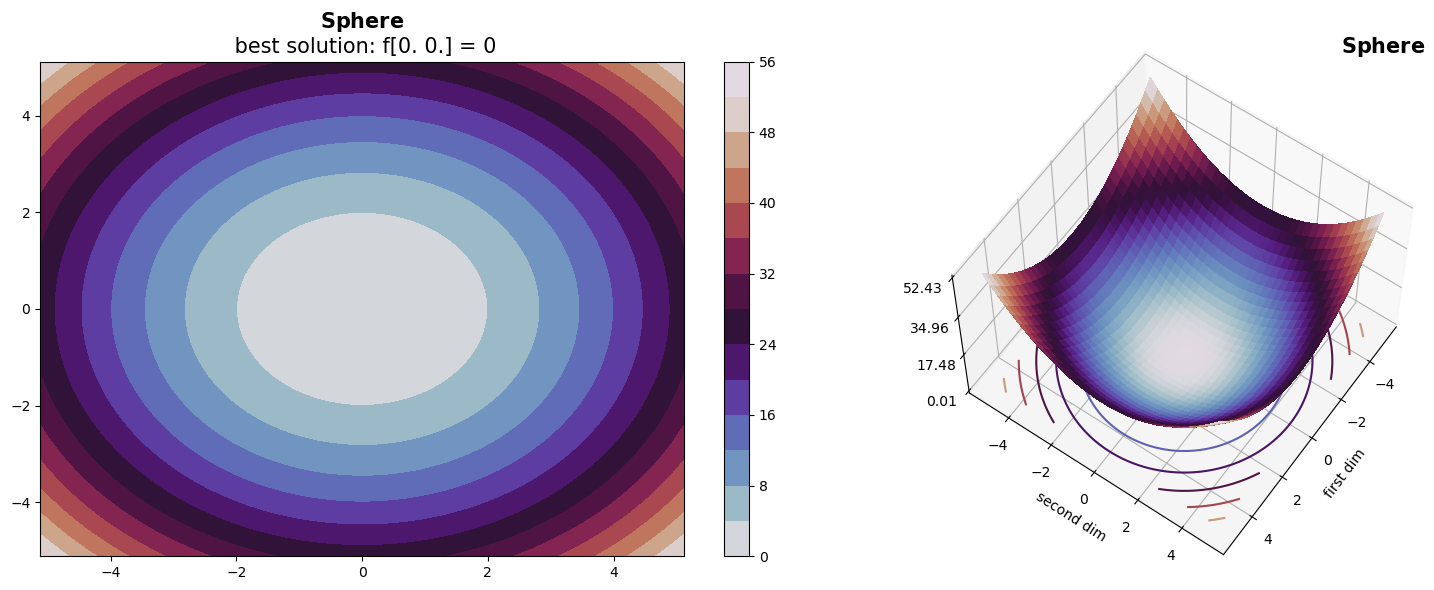

In [68]:
dim = 2
f = Sphere(dim, degree = 2)
plot_3d(f, 
                 points_by_dim= 70, 
                 title = type(f).__name__, 
                 bounds=None, 
                 show_best_if_exists= False, 
                 save_as = None,#f"heatmap for {type(f).__name__}.png",
                 cmap = 'twilight',
                 plot_surface = True,
                 plot_heatmap = True)

In [3]:
def test_quality_function(pwms):
    f = Sphere(dim=5,degree=2)
    return f(pwms)
test_quality_function([2,5,1,6,4])

82

In [ ]:
from skopt import gp_minimize
import pygad
import laserbeamsize as lbs
import numpy as np



# Use the optimal_pwm_values for controlling the deformable mirror

    
def objective(solution):
    A = np.array([[solution[0]], [solution[1]], [solution[2]], [solution[3]], [solution[4]]])
    #with open('PWM_test.csv', 'w', newline='') as file:
    #    mywriter = csv.writer(file, delimiter=',')
    #    mywriter.writerows(A)
    #time.sleep(0.1)
    #image_array = cam.grab(1)    # grab 1 frame
    #image_array=np.array(image_array)
    #image_array=image_array.squeeze()
    #quality_number = get_quality_number(image_array)
    quality_number = -test_quality_function(A)
    score = -quality_number
    print(f"Score: {score}")
    return score[0]

bounds = [(0, 4095)] * 5  # Example bounds for 5 PWM values

# Modify the following parameters as per your requirements
n_calls = 25  # Number of iterations
n_points = 10  # Number of points used for training the surrogate model

res = gp_minimize(objective, bounds, n_calls=n_calls, n_points=n_points)

optimal_pwm_values = res.x
print(optimal_pwm_values)
print(res)


## Benchmark Loop

1. Compare Random to BO
2. Save results for evaluation


In [49]:
def set_PWMs(pwms):
    # Your code that sets the PWMs
    return 0

In [50]:
def get_quality():
    # Your code that calculates the quality number
    quality_number = -99999
    return quality_number

In [51]:
# SYNTHESIS and CHARACTERISATION
def set_PWMs_and_get_quality(pwms,sphere_test=False):
    if sphere_test:
        f = Sphere(dim=5,degree=2)
        return -1*f(pwms)
    else:
        # Zoe fills in above:
        set_PWMs(pwms)
        quality_number = get_quality()
        return quality_number

In [52]:
pip --no-cache-dir install botorch --user

^C
Note: you may need to restart the kernel to use updated packages.


In [53]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

In [54]:
# Random Strategy

import random
def get_random_PWMs():
    return [random.randint(0,4095) for i in range(5)]
get_random_PWMs()

[2156, 1770, 534, 235, 625]

In [55]:
# Bayesian Opt Strategy

import numpy as np
import pandas as pd
def calculate_BO_candidate(samples):
    train_X = samples[["p1","p2","p3","p4","p5"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(-1*train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    from botorch.acquisition import UpperConfidenceBound
    UCB = UpperConfidenceBound(gp, beta=0.1)
    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(5), torch.ones(5)*4095])
    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    return candidate

In [69]:
N_TRIALS = 5
N_ITERATIONS = 50
TEST_FUNCTION = True

best_random_all = []
best_BO_all = []
random_trial_samples =[]
BO_trial_samples =[]
import time
for trial in range(N_TRIALS):
    print(f"Trail {trial}")
    BO_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial',"iteration", "timestamp"])
    random_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    BO_current_candidate = get_random_PWMs() # We will start the BO with a random PWMs as well
    random_current_candidate = get_random_PWMs()
    
    best_random =[]
    best_BO =[]

    for iteration in range(N_ITERATIONS):
        #print(f"Trail {trial}, Iteration {iteration}")
        
        # RANDOM
        # STEP 1 and 2 Synthesis and Characterisation
        random_current_quality = set_PWMs_and_get_quality(random_current_candidate, sphere_test=TEST_FUNCTION)   
        new_sample = {f"p{i+1}":p for i, p in enumerate(random_current_candidate)}
        new_sample["error"] = random_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] =  trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        random_samples = pd.concat([random_samples, new_sample], axis=0, ignore_index=True)    
        # STEP 3 Planning
        random_current_candidate = get_random_PWMs()
        
        # BO
        # STEP 1 and 2 Synthesis and Characterisation
        BO_current_quality = set_PWMs_and_get_quality(BO_current_candidate, sphere_test=TEST_FUNCTION)    
        new_sample = {f"p{i+1}":p for i, p in enumerate(BO_current_candidate)}
        new_sample["error"] = BO_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] =  trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        BO_samples = pd.concat([random_samples, new_sample], axis=0, ignore_index=True)    
        # STEP 3 Planning
        BO_current_candidate = calculate_BO_candidate(BO_samples)
        
        
        # Update Progress
        best_random.append(random_samples["error"].max())
        best_BO.append(BO_samples["error"].max())
        
    random_trial_samples.append(random_samples.copy(deep=True))
    BO_trial_samples.append(BO_samples.copy(deep=True))
    
    best_random_all.append(best_random)
    best_BO_all.append(best_BO)
        

Trail 0
Trail 1
Trail 2
Trail 3
Trail 4


In [70]:
BO_trial_samples[0]

,p1,p2,p3,p4,p5,error,trial,iteration,timestamp
0,1989,2083,3356,3319,1742,-33608071,0,0,1.691582e+09
1,680,3035,78,265,2380,-15414334,0,1,1.691582e+09
2,2154,1407,1790,1967,2183,-18458043,0,2,1.691582e+09
3,1149,3246,1721,2416,2806,-28529250,0,3,1.691582e+09
4,2003,2236,1945,4080,3465,-41447355,0,4,1.691582e+09
5,3219,2272,3429,3942,870,-43578250,0,5,1.691582e+09
6,3050,1624,2296,1834,1673,-23373977,0,6,1.691582e+09
7,1303,2198,536,793,1703,-10345367,0,7,1.691582e+09
8,3539,3851,918,1312,66,-29923146,0,8,1.691582e+09
9,2256,1583,3102,1496,2904,-27889061,0,9,1.691582e+09


In [61]:
best_BO_all

[[-26950696,
  tensor(-22686054.),
  -20657170,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -14116146,
  -13823710,
  -13823710,
  -13823710,
  -13823710,
  -13823710,
  -13823710,
  -13823710,
  -13823710,
  -13823710],
 [-21917250,
  tensor(-9410337.),
  -19313284,
  -19313284,
  -19313284,
  -19313284,
  -19313284,
  -19313284,
  -19313284,
  -19006891,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896,
  -6573896],
 [-36127258,
  -19607671,
  -19607671,
  -19607671,
  -19607671,
  -19607671,
  -19607671,
  -19607671,
  -19607671,
  -18140399,
  -18140399,
  -18140399,
  -18140399,
  -18140399,
  -12648229,
  -12648229,
  -12648229,
  -12648229,
  -12648229,
  -12648229,
  -12648229,
  -12648229,
  -12648229,
  -12648229,
  -12040131],
 [-6561457,
  -65614

## Plot results

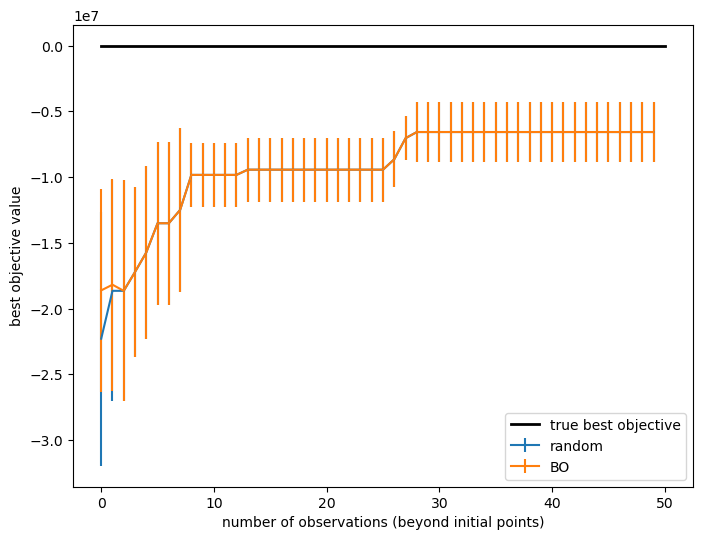

In [71]:
import numpy as np
from matplotlib import pyplot as plt


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = 0 # Sphere is optimised at 0


iters = np.arange(N_ITERATIONS)
y_random = np.asarray(best_random_all)
y_BO = np.asarray(best_BO_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_random.mean(axis=0), yerr=ci(y_random), label="random", linewidth=1.5)
ax.errorbar(iters, y_BO.mean(axis=0), yerr=ci(y_BO), label="BO", linewidth=1.5)
plt.plot(
    [0, N_ITERATIONS],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
#ax.set_ylim(bottom=0.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")